In [ ]:
import os

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
stores_sales = pd.read_csv("train.csv")
stores_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check for null values


In [ ]:
stores_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
#dropping store and item columns
stores_sales = stores_sales.drop(['store', 'item'], axis =1)

In [ ]:
stores_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
#converting date from objest datatype to dateTime datatype
stores_sales['date'] = pd.to_datetime(stores_sales['date'], errors='coerce')

# Check for any NaT values (which were originally invalid dates)
invalid_dates = stores_sales[stores_sales['date'].isna()]

# Display invalid dates for review (optional)
print(f"Number of invalid dates found: {len(invalid_dates)}")
print(invalid_dates)

# Optionally, you can drop or fill these NaT values
# Example: Drop rows with invalid dates
stores_sales = stores_sales.dropna(subset=['date'])


Number of invalid dates found: 0
Empty DataFrame
Columns: [date, sales]
Index: []


In [ ]:
stores_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [ ]:
stores_sales['date'] = pd.to_datetime(stores_sales['date'], errors='coerce')

# Check for any NaT values (which were originally invalid dates)
invalid_dates = stores_sales[stores_sales['date'].isna()]

# Display invalid dates for review (optional)
print(f"Number of invalid dates found: {len(invalid_dates)}")
print(invalid_dates)

# Optionally, you can drop or fill these NaT values
# Example: Drop rows with invalid dates
stores_sales = stores_sales.dropna(subset=['date'])


Number of invalid dates found: 0
Empty DataFrame
Columns: [date, sales]
Index: []


In [ ]:
stores_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [ ]:
#converting date to Month period and then sum the number of items in each month
stores_sales['date'] = stores_sales['date'].dt.to_period('M')
monthly_sales = stores_sales.groupby('date').sum().reset_index()

In [ ]:
#convert the resulting data colum to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()


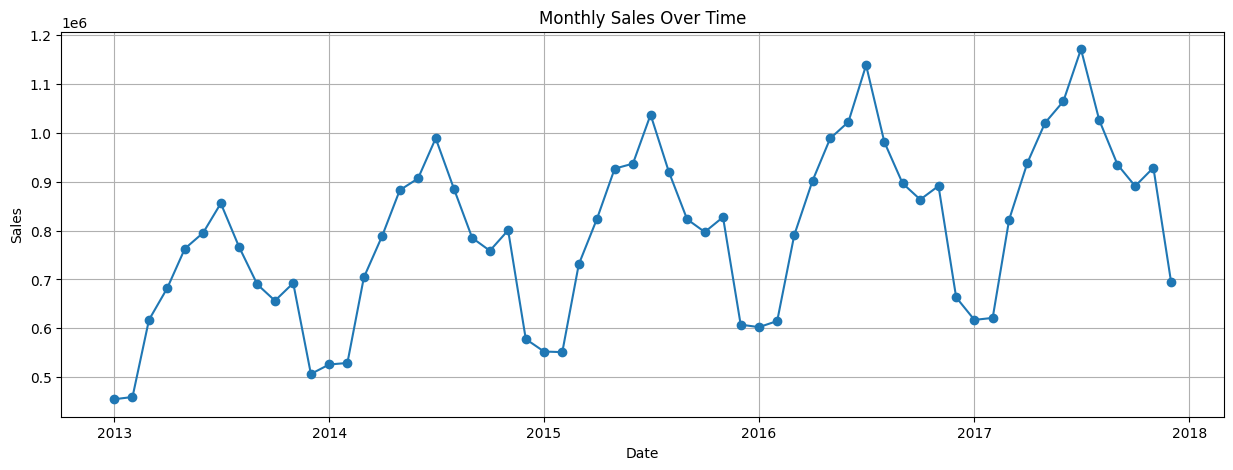

In [ ]:
#visulization
import matplotlib.pyplot as plt

# Assuming monthly_sales['date'] is of type Period
# Convert 'date' from Period to Datetime

# Visualization
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [ ]:
#call the difference on the sales columns to make the sales data stationary
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [ ]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)

In [ ]:
#preparing the supervised data
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0
1,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0
2,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0
3,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0
4,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0
5,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0
6,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0
7,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0
8,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0
9,30392.0,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0


In [ ]:
#splitting the data into training and test data
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (23, 13)
Test Data Shape:  (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
# Assuming train_data and test_data are Pandas DataFrames

# Split the data using .iloc for integer-based indexing
X_train, y_train = train_data[:, 1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]

# If you need to flatten y_train and y_test (which might not be necessary)
y_train = y_train.ravel()  # Converts y_train to a 1D array if needed
y_test = y_test.ravel()    # Converts y_test to a 1D array if needed

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (23, 12)
y_train shape:  (23,)
X_test shape:  (12, 12)
y_test shape:  (12,)


In [ ]:
#make prediction data frame to merge the predicted sales prices of all trained algs
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [ ]:
#To create the linear regression model, and predicted output
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)


In [ ]:
lr_pre = lr_pre.reshape(-1,1)
#this is a set matrix which contains the input featrues of the test data, and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis =1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)


In [ ]:
result_list= []
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)


In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE: ",lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  22043.446890266434
Linear Regression MAE:  16028.038328796052
Linear Regression R2:  0.9813541328509165


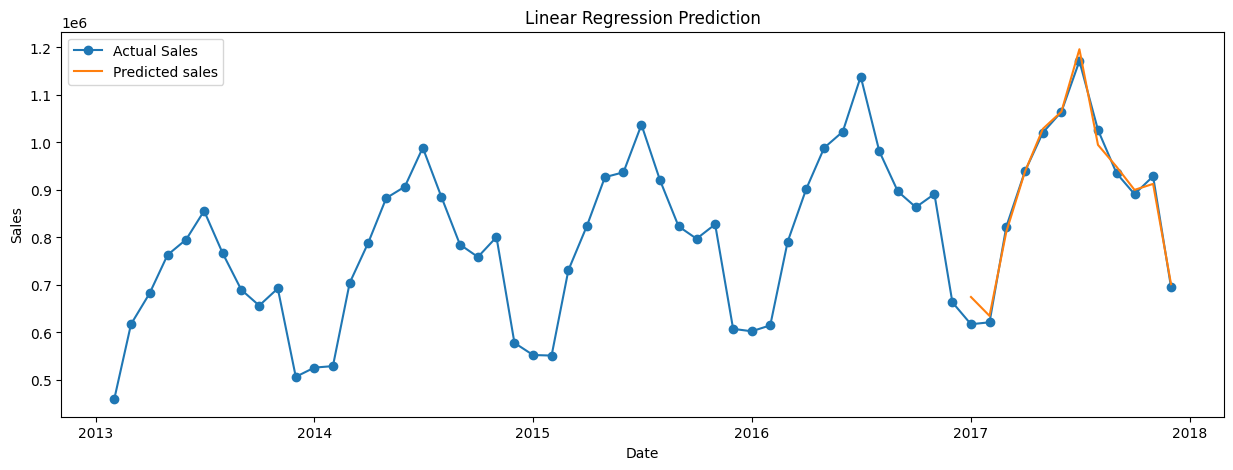

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], marker='o', linestyle='-')
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title('Linear Regression Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()